# Player Similarity via Heatmaps → Serpentine Waves (Premier League 2015/16, StatsBomb Open Data)

## เป้าหมาย (ตาม requirement)
1) สร้าง **heatmap** ของผู้เล่นในฤดูกาลเดียว จาก feature:
- **Passing**: จุดเริ่ม pass (x,y)
- **Receiving**: จุดรับบอล (ปลายทางของ pass: end_location)
- **Carries**: จุดเริ่ม carry (x,y) *(ถ้ามีในข้อมูล)*
- **Position**: “พื้นที่ที่ยืน/มีส่วนร่วม” (ใช้ทุก event ที่มี location)

2) แปลง heatmap (2D) → **wave 1D** ด้วย **serpentine / snake reading**
3) ใช้ **DTW** และ **cosine distance** หา Top-3 ผู้เล่นที่คล้ายที่สุด (same season)

> หมายเหตุ: StatsBomb Open Data มี EPL 2015/16 (competition_id=2, season_id=27) ให้ใช้ฟรี  
Pitch coords: x∈[0,120], y∈[0,80]


In [1]:
# If needed:
# !pip install pandas numpy matplotlib tqdm tslearn requests

import sys
print(sys.executable)

!{sys.executable} -m pip install -U tslearn

c:\Users\Hp\AppData\Local\Programs\Python\Python311\python.exe



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import json
import requests
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1) Download matches + events (EPL 2015/16)

จะดาวน์โหลดไฟล์ events (และ optional lineups) มาเก็บไว้ในโฟลเดอร์ `events/`


In [10]:
BASE = "https://raw.githubusercontent.com/statsbomb/open-data/master/data"

competition_id = 2
season_id = 27  # EPL 2015/16 (open)

matches = requests.get(f"{BASE}/matches/{competition_id}/{season_id}.json", timeout=30).json()
match_ids = [m["match_id"] for m in matches]
len(match_ids), match_ids[:5]

(380, [3754058, 3754245, 3754136, 3754037, 3754039])

In [11]:
Path("events").mkdir(exist_ok=True)

# # for testing purposes because im Tottenham fan
# first5_match_ids = [m["match_id"] for m in matches[:5]]
# # find the match_id for the first match of Tottenham Hotspur
# TEAM = "Tottenham Hotspur"

# spurs_match_id = None

# for m in matches:
#     if (
#         m["home_team"]["home_team_name"] == TEAM
#         or m["away_team"]["away_team_name"] == TEAM
#     ):
#         spurs_match_id = m["match_id"]
#         break
# print(f"Match ID for the first match of {TEAM}: {spurs_match_id}")
# # preview the first 5 match ids and the spurs match id
# match_ids = list(set(first5_match_ids + [spurs_match_id]))


def download(url: str, out_path: Path):
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    out_path.write_bytes(r.content)

for mid in tqdm(match_ids):
    download(f"{BASE}/events/{mid}.json", Path(f"events/{mid}.json"))

  3%|▎         | 10/380 [00:06<04:03,  1.52it/s]


KeyboardInterrupt: 

## 2) Load events และดึง (x,y) สำหรับแต่ละ feature

เราจะสร้าง “จุด” (points) ของแต่ละผู้เล่น:
- pass_start: event type == Pass → location
- pass_receive: event type == Pass → pass.end_location
- carry_start: event type == Carry → location
- position: ทุก event ที่มี location (touch presence)

จากนั้นเก็บเป็น DataFrame แบบ long:
`player, team, feature, x, y`


In [12]:
def load_events(events_dir="events"):
    all_events = []
    for fp in Path(events_dir).glob("*.json"):
        data = json.loads(fp.read_text(encoding="utf-8"))
        all_events.extend(data)
    return all_events

events = load_events()
len(events)

1313783

In [13]:
def extract_feature_points(events):
    rows = []
    for e in events:
        if "player" not in e or "team" not in e:
            continue

        player = e["player"]["name"]
        team = e["team"]["name"]
        etype = e.get("type", {}).get("name", "")

        # 1) Position presence: any location
        loc = e.get("location")
        if isinstance(loc, list) and len(loc) >= 2 and loc[0] is not None and loc[1] is not None:
            rows.append({"player": player, "team": team, "feature": "position", "x": float(loc[0]), "y": float(loc[1])})

        # 2) Passing start (รวม)
        if etype == "Pass":
            if isinstance(loc, list) and len(loc) >= 2 and loc[0] is not None and loc[1] is not None:
                rows.append({"player": player, "team": team, "feature": "passing", "x": float(loc[0]), "y": float(loc[1])})

            # 3) Receiving: pass end_location
            pend = e.get("pass", {}).get("end_location")
            if isinstance(pend, list) and len(pend) >= 2 and pend[0] is not None and pend[1] is not None:
                rows.append({"player": player, "team": team, "feature": "receiving", "x": float(pend[0]), "y": float(pend[1])})

        # 4) Carry start
        if etype == "Carry":
            if isinstance(loc, list) and len(loc) >= 2 and loc[0] is not None and loc[1] is not None:
                rows.append({"player": player, "team": team, "feature": "carries", "x": float(loc[0]), "y": float(loc[1])})

        if etype == "Shot":
            # check if the shot.outcome is "Goal"
            outcome = e.get("shot", {}).get("outcome", {}).get("name", "")
            if outcome == "Goal":
                if isinstance(loc, list) and len(loc) >= 2 and loc[0] is not None and loc[1] is not None:
                    rows.append({"player": player, "team": team, "feature": "goals", "x": float(loc[0]), "y": float(loc[1])})
    return pd.DataFrame(rows)

pts_df = extract_feature_points(events)
pts_df.head(), pts_df["feature"].value_counts()

(                          player          team    feature     x     y
 0  Éderzito António Macedo Lopes  Swansea City   position  61.0  40.1
 1  Éderzito António Macedo Lopes  Swansea City    passing  61.0  40.1
 2  Éderzito António Macedo Lopes  Swansea City  receiving  60.2  40.7
 3                  Jonjo Shelvey  Swansea City   position  60.2  40.7
 4                  Jonjo Shelvey  Swansea City   position  60.5  42.1,
 feature
 position     1305396
 passing       368619
 receiving     368619
 carries       276949
 goals            988
 Name: count, dtype: int64)

## 3) Heatmap generator (binning) + serpentine scan

- สร้าง heatmap 2D ด้วยการ bin ลง grid (bins_x × bins_y)
- normalize ให้เป็น distribution
- แปลง heatmap → wave 1D ด้วย serpentine (snake) scan


In [14]:
def heatmap_2d(points_xy, bins_x=40, bins_y=30, xlim=(0,120), ylim=(0,80)):
    xs = points_xy[:,0]
    ys = points_xy[:,1]

    H, _, _ = np.histogram2d(xs, ys, bins=[bins_x, bins_y], range=[xlim, ylim])
    if H.sum() > 0:
        H = H / H.sum()
    return H

def serpentine_scan(H):
    rows = []
    for i in range(H.shape[0]):
        row = H[i, :]
        rows.append(row if i % 2 == 0 else row[::-1])
    return np.concatenate(rows)

def wave_to_heatmap(wave, bins_x=40, bins_y=30):
    H = np.zeros((bins_x, bins_y), dtype=float)
    k = 0
    for i in range(bins_x):
        row = wave[k:k+bins_y]
        H[i,:] = row if i % 2 == 0 else row[::-1]
        k += bins_y
    return H

## 4) สร้าง wave ต่อผู้เล่น (5 features)

เราจะสร้างตัวแทนผู้เล่นเป็น **multivariate time series**:
- length = bins_x*bins_y (เช่น 1200)
- dim = 5 features (passing, receiving, carries, position, goals)

รูปทรงข้อมูลแต่ละ player: `L × 5`

ถ้า feature ไหนไม่มีข้อมูลของผู้เล่นคนนั้น → เติม 0


In [15]:
FEATURES = ["passing", "receiving", "carries", "position", "goals"]

def build_player_waves(pts_df, bins_x=40, bins_y=30, min_points=30):
    players = sorted(pts_df["player"].unique())
    # print all features available in the dataset
    print("Available features:", pts_df["feature"].unique())
    player_mat = {}
    meta = []

    for p in tqdm(players):
        p_rows = pts_df[pts_df["player"] == p]
        team = p_rows["team"].mode().iloc[0] if len(p_rows) else None

        waves = []
        total_points = 0

        for feat in FEATURES:
            sub = p_rows[p_rows["feature"] == feat]
            pts = sub[["x","y"]].to_numpy(dtype=float)
            total_points += len(pts)

            if len(pts) == 0:
                w = np.zeros(bins_x*bins_y, dtype=float)
            else:
                H = heatmap_2d(pts, bins_x=bins_x, bins_y=bins_y)
                w = serpentine_scan(H)

            waves.append(w)

        # Require at least some activity to avoid junk players
        if total_points < min_points:
            continue

        # stack -> L x 4
        M = np.stack(waves, axis=1)
        player_mat[p] = M
        meta.append({"player": p, "team": team, "total_points": total_points})

    meta_df = pd.DataFrame(meta).sort_values("total_points", ascending=False)
    return player_mat, meta_df

player_ts, meta_df = build_player_waves(pts_df, bins_x=40, bins_y=30, min_points=100)
len(player_ts), meta_df.head()


Available features: ['position' 'passing' 'receiving' 'carries' 'goals']


100%|██████████| 549/549 [01:59<00:00,  4.58it/s]


(512,
                         player             team  total_points
 156  Francesc Fàbregas i Soler          Chelsea         17453
 343                 Mesut Özil          Arsenal         15492
 2                 Aaron Ramsey          Arsenal         14404
 441              Simon Francis  AFC Bournemouth         13596
 36               Andrew Surman  AFC Bournemouth         13113)

## 5) Visualize heatmap ตัวอย่าง (เริ่มจาก passing ก่อน)

เลือกผู้เล่น + feature แล้ว plot heatmap


In [16]:
import matplotlib.pyplot as plt

def draw_full_pitch(ax, color="white", linewidth=1):
    """Draw full football pitch for StatsBomb coords: x in [0,120], y in [0,80]"""
    ax.set_facecolor("#2e7d32")
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)
    ax.set_aspect("equal")
    ax.axis("off")

    # Outer boundaries
    ax.plot([0, 120], [0, 0], color=color, linewidth=linewidth)
    ax.plot([0, 120], [80, 80], color=color, linewidth=linewidth)
    ax.plot([0, 0], [0, 80], color=color, linewidth=linewidth)
    ax.plot([120, 120], [0, 80], color=color, linewidth=linewidth)

    # Halfway line
    ax.plot([60, 60], [0, 80], color=color, linewidth=linewidth)

    # Center circle + spot
    center = (60, 40)
    circle = plt.Circle(center, 10, color=color, fill=False, linewidth=linewidth)
    ax.add_patch(circle)
    ax.scatter([60], [40], color=color, s=12, zorder=5)

    # Penalty areas
    # Left
    ax.plot([0, 18], [18, 18], color=color, linewidth=linewidth)
    ax.plot([18, 18], [18, 62], color=color, linewidth=linewidth)
    ax.plot([18, 0], [62, 62], color=color, linewidth=linewidth)
    # Right
    ax.plot([120, 102], [18, 18], color=color, linewidth=linewidth)
    ax.plot([102, 102], [18, 62], color=color, linewidth=linewidth)
    ax.plot([102, 120], [62, 62], color=color, linewidth=linewidth)

    # 6-yard boxes
    # Left
    ax.plot([0, 6], [30, 30], color=color, linewidth=linewidth)
    ax.plot([6, 6], [30, 50], color=color, linewidth=linewidth)
    ax.plot([6, 0], [50, 50], color=color, linewidth=linewidth)
    # Right
    ax.plot([120, 114], [30, 30], color=color, linewidth=linewidth)
    ax.plot([114, 114], [30, 50], color=color, linewidth=linewidth)
    ax.plot([114, 120], [50, 50], color=color, linewidth=linewidth)

    # Penalty spots
    ax.scatter([12], [40], color=color, s=12, zorder=5)
    ax.scatter([108], [40], color=color, s=12, zorder=5)


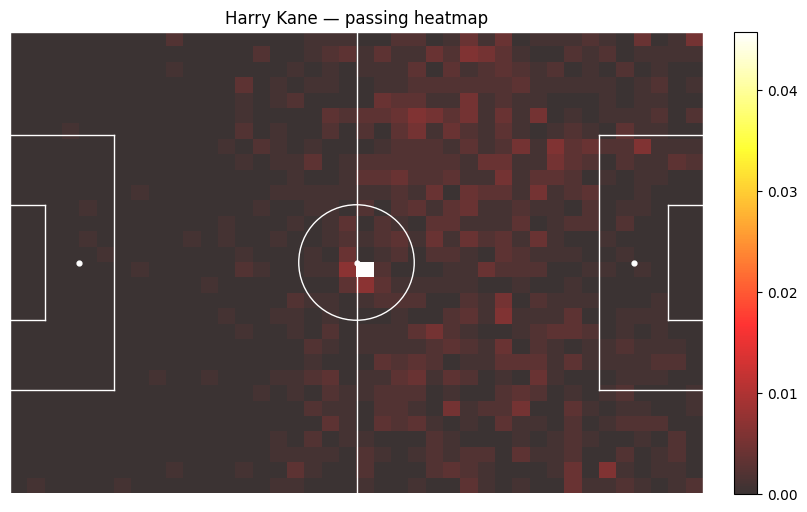

In [17]:
def plot_heatmap_for_player_feature(pts_df, player, feature, bins_x=40, bins_y=30):
    sub = pts_df[(pts_df["player"] == player) & (pts_df["feature"] == feature)]
    pts = sub[["x","y"]].to_numpy(dtype=float)

    if len(pts) == 0:
        print("No points for this feature")
        return

    # build heatmap in pitch coords (StatsBomb: 0–120, 0–80)
    H, xedges, yedges = np.histogram2d(
        pts[:,0], pts[:,1],
        bins=[bins_x, bins_y],
        range=[[0,120],[0,80]]
    )

    if H.sum() > 0:
        H = H / H.sum()

    fig, ax = plt.subplots(figsize=(10,6))

    # draw heatmap using real pitch coordinates
    im = ax.imshow(
        H.T,
        origin="upper",
        extent=[0,120,0,80],   # <<< สำคัญมาก
        cmap="hot",
        alpha=0.8,
        aspect="equal"
    )

    # draw pitch lines
    draw_full_pitch(ax)

    ax.set_title(f"{player} — {feature} heatmap")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.show()


# pick an active player
example_player = "Harry Kane"
plot_heatmap_for_player_feature(pts_df, example_player, "passing")

In [18]:
import numpy as np

def heatmap_2d_from_pts(pts, bins_x=40, bins_y=30):
    """
    pts: numpy array shape (n,2) in StatsBomb coords x[0..120], y[0..80]
    """
    if len(pts) == 0:
        return np.zeros((bins_x, bins_y), dtype=float)

    H, _, _ = np.histogram2d(
        pts[:,0], pts[:,1],
        bins=[bins_x, bins_y],
        range=[[0,120],[0,80]]
    )
    if H.sum() > 0:
        H = H / H.sum()
    return H

def serpentine_scan(H):
    rows = []
    for i in range(H.shape[0]):
        row = H[i, :]
        rows.append(row if i % 2 == 0 else row[::-1])
    return np.concatenate(rows)

def player_feature_to_wave(pts_df, player, feature="passing", bins_x=40, bins_y=30):
    sub = pts_df[(pts_df["player"] == player) & (pts_df["feature"] == feature)]
    pts = sub[["x","y"]].to_numpy(dtype=float)
    H = heatmap_2d_from_pts(pts, bins_x=bins_x, bins_y=bins_y)
    w = serpentine_scan(H)
    return w, H


In [19]:
def build_player_ts_from_heatmap(pts_df, feature="passing", bins_x=40, bins_y=30, min_points=10):
    player_ts = {}
    for p in pts_df.loc[pts_df["feature"] == feature, "player"].unique():
        sub = pts_df[(pts_df["player"] == p) & (pts_df["feature"] == feature)]
        if len(sub) < min_points:
            continue
        w, _ = player_feature_to_wave(pts_df, p, feature=feature, bins_x=bins_x, bins_y=bins_y)
        player_ts[p] = w
    return player_ts

feature = "passing"
player_ts = build_player_ts_from_heatmap(pts_df, feature=feature, bins_x=40, bins_y=30, min_points=10)

len(player_ts), list(player_ts.keys())[:5]


(520,
 ['Éderzito António Macedo Lopes',
  'Jonjo Shelvey',
  'Leon Britton',
  'Kyle Bartley',
  'Ashley Williams'])

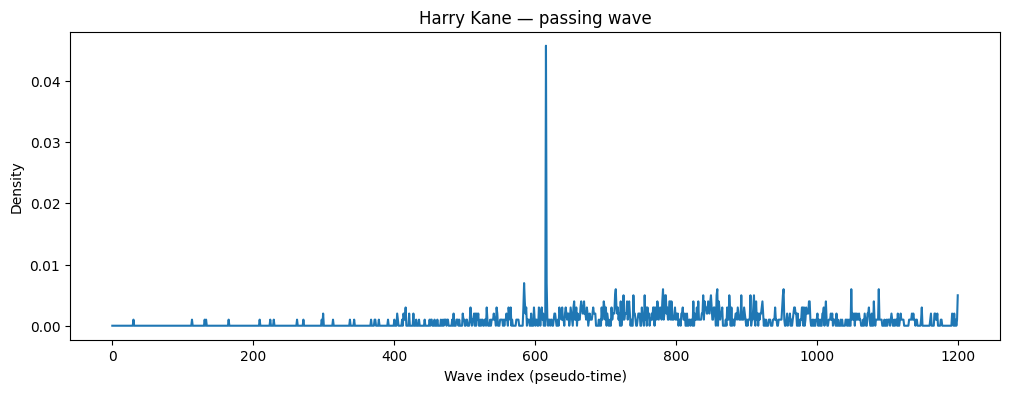

In [20]:
import matplotlib.pyplot as plt

def plot_player_wave(player_ts, player, title=""):
    w = player_ts[player]
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(w)
    ax.set_title(title or f"Serpentine wave — {player}")
    ax.set_xlabel("Wave index (pseudo-time)")
    ax.set_ylabel("Density")
    plt.show()

target = example_player  # เช่น "Harry Kane" (ต้องมีใน player_ts)
plot_player_wave(player_ts, target, title=f"{target} — {feature} wave")


In [21]:
def plot_compare_waves(player_ts, target, sim_list, title=""):
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(player_ts[target], label=f"TARGET: {target}", linewidth=2)

    for p, d in sim_list:
        ax.plot(player_ts[p], label=f"{p} (d={d:.3f})", alpha=0.8)

    ax.set_title(title or "Wave comparison (serpentine)")
    ax.set_xlabel("Wave index")
    ax.legend()
    plt.show()

## 6) Plot serpentine wave comparison using dtw

หาคนที่เหมือนกัน top 3 และ Plot waves


In [ ]:
from tslearn.metrics import dtw
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

def dtw_distance(a, b):
    # ensure 1D numpy arrays
    a = np.asarray(a, dtype=float).ravel()
    b = np.asarray(b, dtype=float).ravel()
    return float(dtw(a, b))

def topk_similar_players_dtw(player_ts, target_player, k=3):
    if target_player not in player_ts:
        raise ValueError("target_player not found")

    tgt = player_ts[target_player]
    scores = []

    for p, ts in tqdm(player_ts.items()):
        if p == target_player:
            continue
        d = dtw_distance(tgt, ts)
        scores.append((p, d))

    scores.sort(key=lambda x: x[1])
    return scores[:k]

In [23]:
target = example_player
sim = topk_similar_players_dtw(player_ts, target, k=3)
print("Target:", target)
print("Top-3 (DTW):", sim)

100%|██████████| 520/520 [00:10<00:00, 49.65it/s]

Target: Harry Kane
Top-3 (DTW): [('Olivier Giroud', 0.024371373769584335), ('Shane Long', 0.025745859281174118), ('Graziano Pellè', 0.027406689749092078)]


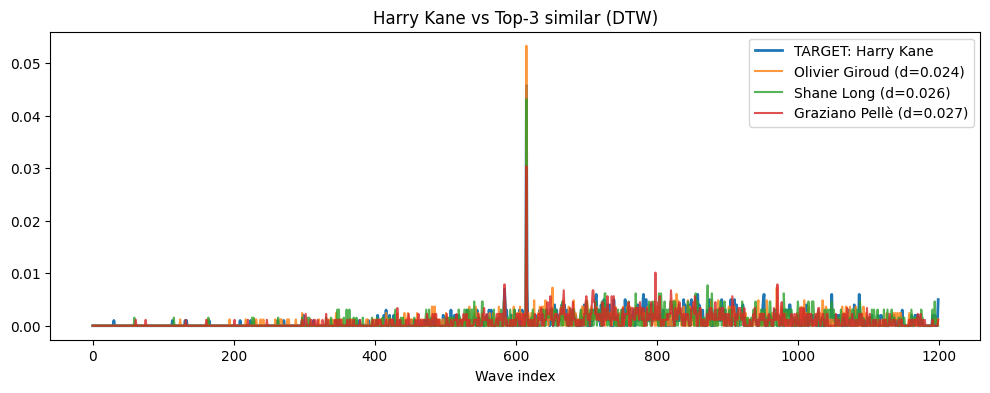

In [24]:
plot_compare_waves(player_ts, target, sim, title=f"{target} vs Top-3 similar (DTW)")

## 7) Plot serpentine wave comparison using cosine_distance

หาคนที่เหมือนกัน top 3 และ Plot waves


In [25]:
from tqdm import tqdm

def cosine_distance(a, b):
    a = np.asarray(a, dtype=float).ravel()
    b = np.asarray(b, dtype=float).ravel()
    return float(cosine_distances([a], [b])[0][0])

def topk_similar_players_cosine(player_ts, target_player, k=3):
    if target_player not in player_ts:
        raise ValueError("target_player not found")

    tgt = player_ts[target_player]
    scores = []

    for p, ts in tqdm(player_ts.items()):
        if p == target_player:
            continue
        d = cosine_distance(tgt, ts)
        scores.append((p, d))

    scores.sort(key=lambda x: x[1])
    return scores[:k]


In [26]:
target = example_player
sim_cos = topk_similar_players_cosine(player_ts, target, k=3)

print("Target:", target)
print("Top-3 (Cosine):", sim_cos)


  0%|          | 0/520 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:00<00:00, 1522.16it/s]

Target: Harry Kane
Top-3 (Cosine): [('Romelu Lukaku Menama', 0.20486469328526924), ('Diego da Silva Costa', 0.20519110574258426), ('Aleksandar Mitrović', 0.21931976712516899)]


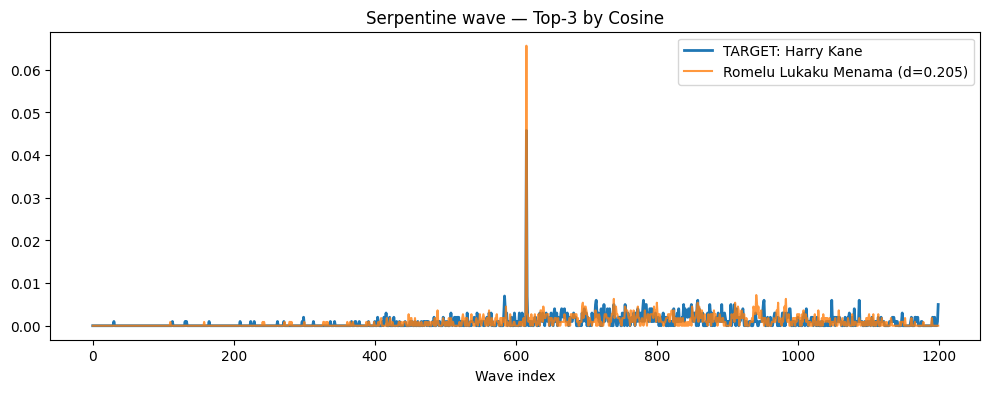

In [27]:
# only plot the nearest player
sim_cos_top1 = sim_cos[0:1]  # take only the top-1
plot_compare_waves(player_ts, target, sim_cos_top1, title="Serpentine wave — Top-3 by Cosine")


## 7) Compare heatmaps ระหว่าง target กับ similar players

เพื่อให้ดูเข้าใจง่าย: แสดง heatmap ของ feature เดียวกัน (เช่น passing) ของ 4 คน (target + top3)


100%|██████████| 520/520 [00:00<00:00, 5005.12it/s]


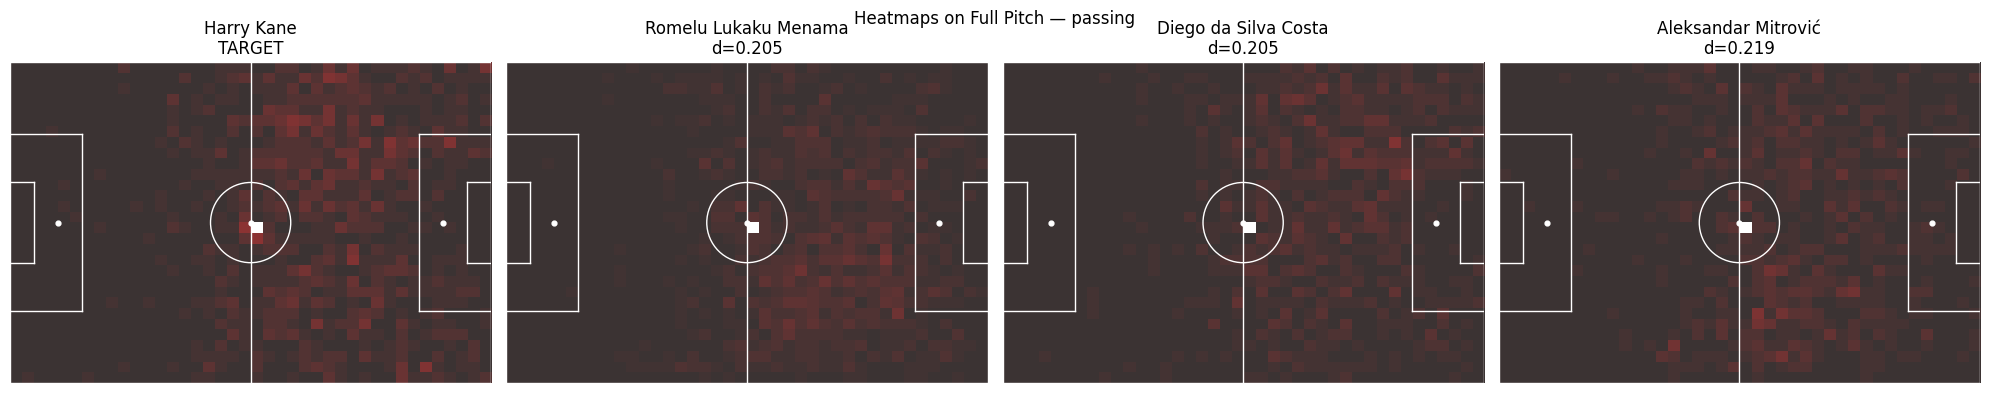

In [32]:
def compare_heatmaps(pts_df, target_player, sim_players, feature="passing", bins_x=40, bins_y=30):
    names = [target_player] + [p for p,_ in sim_players]
    fig, axes = plt.subplots(1, len(names), figsize=(5*len(names), 4))

    if len(names) == 1:
        axes = [axes]

    for ax, name in zip(axes, names):
        sub = pts_df[(pts_df["player"] == name) & (pts_df["feature"] == feature)]
        pts = sub[["x","y"]].to_numpy(dtype=float)

        if len(pts) == 0:
            ax.set_title(f"{name}\n(no data)")
            ax.axis("off")
            continue

        # build heatmap aligned to StatsBomb pitch coords
        H, _, _ = np.histogram2d(
            pts[:,0], pts[:,1],
            bins=[bins_x, bins_y],
            range=[[0,120],[0,80]]
        )

        if H.sum() > 0:
            H = H / H.sum()

        im = ax.imshow(
            H.T,
            origin="upper",
            extent=[0,120,0,80],
            cmap="hot",
            alpha=0.8,
            aspect="equal"
        )

        # draw pitch overlay (ต้องมี draw_full_pitch(ax) อยู่แล้ว)
        draw_full_pitch(ax)

        # ใส่ distance ใน title ด้วย (ถ้ามี)
        dist_map = dict(sim_players)
        if name == target_player:
            ax.set_title(f"{name}\nTARGET")
        else:
            ax.set_title(f"{name}\nd={dist_map.get(name, float('nan')):.3f}")
    # add more margin bottom of the title
    plt.subplots_adjust(bottom=0.15)
    plt.suptitle(f"Heatmaps on Full Pitch — {feature}")

    plt.tight_layout()
    plt.show()

sim = topk_similar_players_cosine(player_ts, target, k=3)
compare_heatmaps(pts_df, target, sim, feature="passing")

### 8) Export data points contains column feature
Waves for all features

In [33]:
import numpy as np
import pandas as pd

BINS_X, BINS_Y = 40, 30

def heatmap_2d_from_pts(pts, bins_x=BINS_X, bins_y=BINS_Y):
    if len(pts) == 0:
        return np.zeros((bins_x, bins_y), dtype=float)
    H, _, _ = np.histogram2d(
        pts[:,0], pts[:,1],
        bins=[bins_x, bins_y],
        range=[[0,120],[0,80]]
    )
    if H.sum() > 0:
        H = H / H.sum()
    return H

def serpentine_scan(H):
    rows = []
    for i in range(H.shape[0]):
        row = H[i, :]
        rows.append(row if i % 2 == 0 else row[::-1])
    return np.concatenate(rows)

def build_waves_df(pts_df, feature="passing", min_points=10):
    rows = []
    players = pts_df.loc[pts_df["feature"] == feature, "player"].unique()
    for p in players:
        sub = pts_df[(pts_df["player"] == p) & (pts_df["feature"] == feature)]
        if len(sub) < min_points:
            continue
        pts = sub[["x","y"]].to_numpy(dtype=float)
        H = heatmap_2d_from_pts(pts)
        w = serpentine_scan(H)

        rec = {"player": p, "feature": feature, "n_points": len(sub)}
        for i, val in enumerate(w):
            rec[f"wave_{i}"] = float(val)
        rows.append(rec)

    return pd.DataFrame(rows)

# -------- EXPORT --------
# 1) points for heatmap
pts_df.to_csv("points.csv", index=False)
print("Saved points.csv")

# 2) waves for similarity
for feat in FEATURES:
    waves_df = build_waves_df(pts_df, feature=feat, min_points=10)
    waves_df.to_csv(f"waves_{feat}.csv", index=False)
    print("Saved", f"waves_{feat}.csv", "rows=", len(waves_df))




Saved points.csv
Saved waves_passing.csv rows= 520
Saved waves_receiving.csv rows= 520
Saved waves_carries.csv rows= 516
Saved waves_position.csv rows= 546
Saved waves_goals.csv rows= 21
